<a href="https://colab.research.google.com/github/FaisalT0435/Sistem-Deteksi-Hama-menggunakan-Deep-learning-dan-IoT/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Jan 25 07:09:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U torchvision 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [ ]:
class PestDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [ ]:
#Memanggil dataset
dataset_path = "/content/drive/MyDrive/Ta/Faster_RCNN/Dataset"

In [ ]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=8.82s)
creating index...
index created!


{0: {'id': 0, 'name': 'Padi', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'Belalang', 'supercategory': 'Padi'},
 2: {'id': 2, 'name': 'Padi', 'supercategory': 'Padi'},
 3: {'id': 3, 'name': 'Ulat', 'supercategory': 'Padi'},
 4: {'id': 4, 'name': 'Wereng', 'supercategory': 'Padi'}}

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Padi', 'Belalang', 'Padi', 'Ulat', 'Wereng']

In [ ]:
train_dataset = PestDetection(root=dataset_path, transforms=get_transforms(True))
test_dataset = PestDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=2.33s)
creating index...
index created!


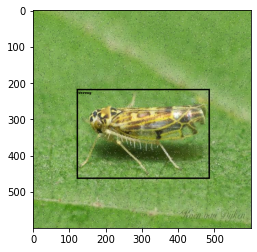

In [ ]:
sample = train_dataset[8]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [ ]:
len(train_dataset)

1671

In [ ]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
in_features

1024

In [ ]:
# images,targets = next(iter(train_dataset))
# images
# # from torchmetrics.classification import MultilabelConfusionMatrix
# # confmat = MultilabelConfusionMatrix(num_labels=2)
# # confmat(images, targets)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
test_dataset = PestDetection(root=dataset_path, split="valid", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.89s)
creating index...
index created!


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
# valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)


In [ ]:
images,targets = next(iter(train_loader))

images[0]


tensor([[[0.3412, 0.3412, 0.3412,  ..., 0.4824, 0.4549, 0.4627],
         [0.3412, 0.3412, 0.3412,  ..., 0.4706, 0.4784, 0.4941],
         [0.3412, 0.3412, 0.3412,  ..., 0.4902, 0.4863, 0.3804],
         ...,
         [0.4902, 0.5529, 0.4667,  ..., 0.4353, 0.4275, 0.4275],
         [0.4941, 0.5294, 0.5020,  ..., 0.4275, 0.4314, 0.4314],
         [0.5216, 0.4902, 0.5020,  ..., 0.4275, 0.4314, 0.4353]],

        [[0.5765, 0.5765, 0.5765,  ..., 0.6863, 0.6588, 0.6667],
         [0.5765, 0.5765, 0.5765,  ..., 0.6745, 0.6784, 0.6980],
         [0.5765, 0.5765, 0.5765,  ..., 0.6824, 0.6784, 0.5647],
         ...,
         [0.6745, 0.7333, 0.6510,  ..., 0.6667, 0.6706, 0.6706],
         [0.6784, 0.7176, 0.6902,  ..., 0.6667, 0.6745, 0.6745],
         [0.7059, 0.6745, 0.6902,  ..., 0.6706, 0.6745, 0.6784]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0157, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0235, 0.0353, 0.

In [ ]:
# targets[0]

In [ ]:
# from torchmetrics.classification import BinaryConfusionMatrix
# confmat = BinaryConfusionMatrix()
# confmat(images, targets)

In [ ]:
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

In [ ]:
# from torchmetrics.functional.classification import multilabel_confusion_matrix

In [ ]:
# preds = images

In [ ]:
# target = targets

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 10.5 MB/s eta 0:00:00


In [ ]:
# from torchmetrics.classification import MulticlassAccuracy

In [ ]:
device = torch.device("cuda")

In [ ]:
model = model.to(device)

In [ ]:
# from torch.optim import Adam

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-5,  weight_decay=5e-4)

In [ ]:
import os

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    for images, targets in tqdm(loader):
      
          images = list(image.to(device) for image in images)
          targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
          
          loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
          losses = sum(loss for loss in loss_dict.values())
          loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
          loss_value = losses.item()
          
          all_losses.append(loss_value)
          all_losses_dict.append(loss_dict_append)
          
          if not math.isfinite(loss_value):
              print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
              print(loss_dict)
              sys.exit(1)
          
          optimizer.zero_grad()
          losses.backward()
          optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
    # print(f"Avg train Loss: {np.mean(all_losses)}")
    return np.mean(all_losses)
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
best_vloss = np.inf
def validate(loader, model, optimizer, device, epoch):
    global best_vloss
    loop = tqdm(loader)
    running_vloss = 0
    for batch_idx, (images, targets) in enumerate(loop):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
          loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        running_vloss += losses
        
    avg_vloss = running_vloss / (batch_idx + 1)
    print(f"Avg Valid Loss: {avg_vloss}")
    if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      # if SAVE_MODEL:
      #       print("Model improved, saving...")
      #       checkpoint = {
      #           "state_dict": model.state_dict(),
      #           "optimizer": optimizer.state_dict(),
      #       }
      #       save_checkpoint(checkpoint, filename=f"1152KaggleBest_second_{epoch}.pth.tar")
    print('\n')
    return avg_vloss

In [ ]:
num_epochs=25
train_error = []
val_error = []
for epoch in range(num_epochs):
    train=train_one_epoch(model, optimizer, train_loader, device, epoch)
    vloss= validate(test_loader, model, optimizer, device, epoch)
    train_error.append(train*100)
    val_error.append(vloss.tolist()*100)
    
  

100%|██████████| 31/31 [00:13<00:00,  2.36it/s]


Avg Valid Loss: 0.17044562101364136




100%|██████████| 31/31 [00:11<00:00,  2.62it/s]


Avg Valid Loss: 0.14102748036384583




100%|██████████| 31/31 [00:11<00:00,  2.60it/s]


Avg Valid Loss: 0.13612693548202515




100%|██████████| 31/31 [00:11<00:00,  2.61it/s]


Avg Valid Loss: 0.13787050545215607




100%|██████████| 31/31 [00:11<00:00,  2.61it/s]


Avg Valid Loss: 0.13164357841014862




100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


Avg Valid Loss: 0.1302657127380371




100%|██████████| 31/31 [00:11<00:00,  2.61it/s]


Avg Valid Loss: 0.12857238948345184




100%|██████████| 31/31 [00:11<00:00,  2.61it/s]


Avg Valid Loss: 0.1266741007566452




100%|██████████| 31/31 [00:11<00:00,  2.60it/s]


Avg Valid Loss: 0.13041798770427704




100%|██████████| 31/31 [00:12<00:00,  2.58it/s]


Avg Valid Loss: 0.12578816711902618




100%|██████████| 31/31 [00:11<00:00,  2.61it/s]


Avg Valid Loss: 0.12856943905353546




100%|██████████| 31/31 [00:12<00:00,  2.57it/s]


Avg Valid Loss: 0.12364964932203293




100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


Avg Valid Loss: 0.12216836959123611




  1%|▏         | 6/418 [00:05<05:34,  1.23it/s]

In [ ]:
train_error

In [ ]:
vloss.tolist()

In [ ]:
# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(train_acc, label='Train Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([0.3, 1.1])
# plt.axvline(best_ntree_limit-1, color="gray", label="Optimal tree number")
# plt.title('Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(train_error, label='Training Loss')
plt.plot(val_error, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.axvline(num_epochs, color="gray", label="Epoch")
# plt.ylabel('merror')
plt.ylabel('Loss')

plt.show()

In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
len(test_dataset)

In [ ]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [ ]:
# print("Score")

# img, _ = test_dataset[10]
# # print(images)
# # print(img)
# img_int = torch.tensor(img*255, dtype=torch.uint8)

# with torch.no_grad():
#       # _, predicted = torch.max(img.data, 2)
#       prediction = model([img.to(device)])
#       # print(prediction)
#       pred = prediction[0]
#       # x = model([images.to(device)])
#       # print(pred)
      
#       # # print(pred)
#       # x = pred['scores'] > 0.7
#       # print(x)
#       # print(targets[0])
#       # images = list(image.to(device) for image in images)
#       # print(images)
#       metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=None, rec_thresholds=None, max_detection_thresholds=None, class_metrics=False)
#       metric.update(pred, images)
#       # from pprint import pprint
#       # pprint(metric.compute())
      

  
  
    
  


In [ ]:
print("Score")
for i in range(4):
  img, _ = test_dataset[i]
  img_int = torch.tensor(img*255, dtype=torch.uint8)
  with torch.no_grad():
      prediction = model([img.to(device)])
      pred = prediction[0]
      
  
  # print(prediction,targets[1]['labels'])
  
  print( [classes[i] for i in pred['labels'][pred['scores'] > 0.7].tolist()], ": ",pred['scores'].tolist() )
  fig = plt.figure(figsize=(14, 10))
  plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8], 
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
  ).permute(1, 2, 0))

  
  
    
  


In [ ]:
# img, _ = test_dataset[3]
# img_int = torch.tensor(img*255, dtype=torch.uint8)
# with torch.no_grad():
#       prediction = model([img.to(device)])
#       pred = prediction[0]
      
  
# print(prediction,targets[1]['labels'])
  
#   # print( [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], ": ",pred['scores'].tolist() )
# fig = plt.figure(figsize=(14, 10))
# plt.imshow(draw_bounding_boxes(img_int,
#     pred['boxes'][pred['scores'] > 0.4], 
#     [classes[i] for i in pred['labels'][pred['scores'] > 0.4].tolist()], width=4
#   ).permute(1, 2, 0))


In [ ]:
# from sklearn import metrics

In [ ]:
# prediction
# # multilabel_confusion_matrix(images[0], prediction, num_labels=4)